First we need to import all of the libraries we need

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
from matplotlib import pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics
from collections import Counter

Now we need to import the dataset (The link of the dataset: https://www.kaggle.com/datasets/kartik2112/fraud-detection/data)

In [2]:
original_dataset = pd.read_csv("fraudTrain.csv")

Then, we need to check out if the data is imbalance so we print out the percentage of the data labeled as fraud to check it out.

In [3]:
# get the number of unique values in the label column ("is_fraud")
unique_labels = original_dataset['is_fraud'].value_counts()

# get the percentages of them
percentages = unique_labels / len(original_dataset) * 100

# print the result out
print(percentages)

is_fraud
0    99.421135
1     0.578865
Name: count, dtype: float64


In [4]:
pd.options.display.max_columns = None
original_dataset.head()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,state,zip,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,NC,28654,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0
1,1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,WA,99160,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0
2,2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,Malad City,ID,83252,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0
3,3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,Boulder,MT,59632,46.2306,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0
4,4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,Doe Hill,VA,24433,38.4207,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0


For better understanding to the dataset and remove reduntant features we will test if the fraud trans are correlated to speific cities or not so we will see the mean of the fraud samples within each city

Before we split the data into features and labels we will check if the data has any duplicates.

In [5]:
original_dataset.duplicated().any()

False

After studies for the feartures in the dataset and see the importances for each one regarding to the Random Forest model I removed some reduntant features or the features which are less contributing for the model and I find out that the dataset contains the latitude and longitude for the user and merchant and each one of them by itself doesn't have a high importance but making a new feature which is the distance between the user's location and the merchant's location will add a useful information and encapsulates all of those features so removing them after adding this new feature will make a better performance.

The distance will be computed by The Haversine formula and it's commonly used for this purpose as it calculates the distance between two points on the surface of a sphere, which is a good approximation for Earth. 

In [6]:
def haversine(lat1, lon1, lat2, lon2):
    # Convert latitude and longitude from degrees to radians
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])

    # Haversine formula
    dlat = lat2 - lat1 
    dlon = lon2 - lon1 
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))

    # Radius of Earth in kilometers (use 3956 for miles)
    r = 6371  
    return c * r

Now apply the function on the dataset to add the new feature ('distance')

In [7]:
original_dataset['distance'] = haversine(
    original_dataset['lat'], original_dataset['long'],
    original_dataset['merch_lat'], original_dataset['merch_long']
)

Remove the reduntant or low imortance features and then split the data into features and labels and then convert the categorical features into numerical ones.
The dataset have the following types of features {object, int64, float64} so we will convert all columns of object type and encode it to be numerical

In [8]:
# creating a dataframe contains only the features by dropping the label column
features = original_dataset.drop(columns=['is_fraud','gender','lat','long','merch_lat','merch_long','trans_date_trans_time','first','last','trans_num','job','state','city']) 

# delete the first column as it's just index of each row
# features = features.drop(features.columns[0],axis=1)
features = features.loc[:, ~features.columns.str.contains('^Unnamed')]

# create the label column
label = original_dataset['is_fraud']

# convert the categorical features into numrical
# first we need to define the encoder 
encoder = LabelEncoder()
# then apply encoding on each feature of type ('object') 

for feature in features:
    if features[feature].dtype == 'object':
        features[feature] = encoder.fit_transform(features[feature])

features.head()



,cc_num,merchant,category,amt,street,zip,city_pop,dob,unix_time,distance
0,2703186189652095,514,8,4.97,568,28654,3495,779,1325376018,78.597568
1,630423337322,241,4,107.23,435,99160,149,607,1325376044,30.212176
2,38859492057661,390,0,220.11,602,83252,4154,302,1325376051,108.206083
3,3534093764340240,360,2,45.00,930,59632,1939,397,1325376076,95.673231
4,375534208663984,297,9,41.96,418,24433,99,734,1325376186,77.556744


The feature ('cc_num') is considered as ('Int64') and it has a wide range of value which consumes a lot of time to train so we will consider it as a categorical feature and encode it to narrow the range of values.


In [9]:
# convert the feature 'cc_num' to categorical feature
features['cc_num'] = features['cc_num'].astype('object')

# encode the feature's values
features['cc_num'] = encoder.fit_transform(features['cc_num'])

features.head()

,cc_num,merchant,category,amt,street,zip,city_pop,dob,unix_time,distance
0,444,514,8,4.97,568,28654,3495,779,1325376018,78.597568
1,42,241,4,107.23,435,99160,149,607,1325376044,30.212176
2,237,390,0,220.11,602,83252,4154,302,1325376051,108.206083
3,509,360,2,45.00,930,59632,1939,397,1325376076,95.673231
4,368,297,9,41.96,418,24433,99,734,1325376186,77.556744


Now we need to split our data into training and testing sets

In [10]:
from sklearn.model_selection import train_test_split

features_train , features_test , label_train , label_test = train_test_split(features,label,test_size=0.2,random_state=42,stratify=label)


As the dataset is imbalanced so using the SMOTE technique to oversample the fraud samples to get better Recall and Precision for the fraud class.

In [11]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
features_train_smote, label_train_smote = smote.fit_resample(features_train, label_train)


Import and train the random forest model and we will train it once on the SMOTE datasets and another time without the SMOTE technique and using the hyperparameter class = 'balance' instead to see which of them handles the imbalance better

In [12]:
from sklearn.ensemble import RandomForestClassifier


model = RandomForestClassifier(250,random_state=42, n_jobs= -1,)

# Train the model
model.fit(features_train_smote, label_train_smote)

RandomForestClassifier(n_estimators=250, n_jobs=-1, random_state=42)

Now we will make predictions and see a report of the errors measuring the misclassified samples

In [13]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Make predictions on the test set
label_predictions = model.predict(features_test)

# Print classification report
print(classification_report(label_test, label_predictions))

              precision    recall  f1-score   support

           0       1.00      0.99      1.00    257834
           1       0.38      0.79      0.52      1501

    accuracy                           0.99    259335
   macro avg       0.69      0.89      0.76    259335
weighted avg       1.00      0.99      0.99    259335



Trying to fit another model without the SMOTE and instead using tha class_weight parameter to balance the data with the appropiate hyperparameters

In [15]:
model_balance = RandomForestClassifier(250,min_samples_leaf=4,class_weight='balanced',random_state=42,n_jobs=-1)

model_balance.fit(features_train,label_train)

RandomForestClassifier(class_weight='balanced', min_samples_leaf=4,
                       n_estimators=250, n_jobs=-1, random_state=42)

Evaluate the balanced model

In [16]:
# Make predictions on the test set
label_predictions_balance = model_balance.predict(features_test)

# Print classification report
print(classification_report(label_test, label_predictions_balance))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    257834
           1       0.74      0.79      0.76      1501

    accuracy                           1.00    259335
   macro avg       0.87      0.89      0.88    259335
weighted avg       1.00      1.00      1.00    259335



As we see with trying with both ways and tuning the hyperparameters the SMOTE achieved a higher Recall in the fraud casses than the balance but the balance achieved a higher precision for the fraud class and higher overall accuarcy so the choice depending on your objectives If your primary goal is to identify as many fraud cases as possible (maximize recall) the SMOTE will be better and if the cost of false positives (misclassifying non-fraud as fraud) is high, the model without SMOTE will be better.

Some analysis about feature engineering helped in tuning the models and selection the important features.

Now we can see the feature importance of each feature to see how many features that really influences the decision and identifies a number of the most important features so first we will get the feature importances from the model.

In [37]:
# Get the feature impportances
importances = model.feature_importances_

# Create a DataFrame to display the feature importance along with feature names
feature_importance_df = pd.DataFrame({
    'Feature': features_train.columns,
    'Importance': importances
})

# Sort the features by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

feature_importance_df

,Feature,Importance
3,amt,0.652574
2,category,0.094996
8,unix_time,0.050530
1,merchant,0.037524
7,dob,0.033032
6,city_pop,0.032399
5,zip,0.026749
0,cc_num,0.026504
4,street,0.024865
9,distance,0.020827


In [19]:
print(confusion_matrix(label_test, label_predictions))

[[257457    377]
 [   350   1151]]


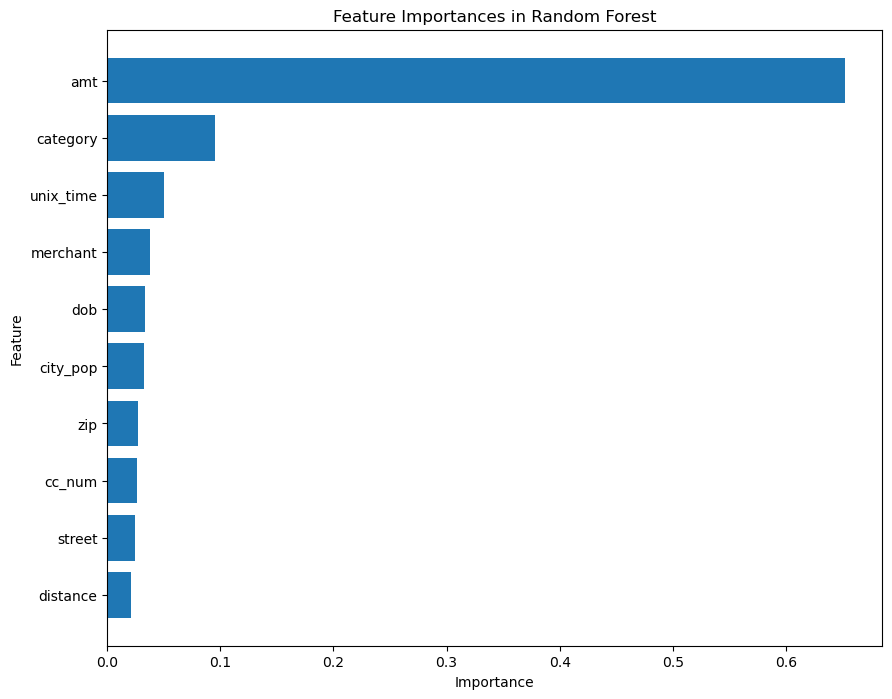

In [38]:
import matplotlib.pyplot as plt

# Plot feature importances
plt.figure(figsize=(10, 8))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances in Random Forest')
plt.gca().invert_yaxis()  # To display the most important feature at the top
plt.show()